# Modeling - KNN Regression

In [2]:
import pickle
import pandas as pd
import numpy as np
import yaml

In [3]:
try:
    with open("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading config file')

## Datetime info represented cyclically, no OneHotEncoded station ids

In [4]:
data_cyc = pd.read_csv(config['data']['data_with_ids_cyc'])

In [5]:
data_cyc

,weekday,start_station_id,count,start_station_name,start_lat,start_lng,temperature_f,precipitation_in,windspeed_mph,special_event,week_number_sin,week_number_cos,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,4,4993.13,1,Old Slip & South St,40.703367,-74.007868,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-5.000000e-01,-0.866025,0.433884,0.433884,0.000000,1.000000
1,4,5065.12,1,William St & Pine St,40.707179,-74.008873,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-5.000000e-01,-0.866025,0.433884,0.433884,0.000000,1.000000
2,4,5114.06,1,West Thames St,40.708347,-74.017134,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-5.000000e-01,-0.866025,0.433884,0.433884,0.000000,1.000000
3,4,5137.11,1,Fulton St & William St,40.709601,-74.006551,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-5.000000e-01,-0.866025,0.433884,0.433884,0.000000,1.000000
4,4,5137.13,1,Spruce St & Gold St,40.710323,-74.004323,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-5.000000e-01,-0.866025,0.433884,0.433884,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321124,5,5216.06,9,Vesey St & Church St,40.712455,-74.010822,68.8,0.0,4.7,0,-3.216245e-16,-1.0,1.224647e-16,-1.000000,-0.433884,-0.433884,-0.258819,0.965926
321125,5,5288.08,1,Park Pl & Church St,40.713089,-74.009329,68.8,0.0,4.7,0,-3.216245e-16,-1.0,1.224647e-16,-1.000000,-0.433884,-0.433884,-0.258819,0.965926
321126,5,5288.09,4,Warren St & W Broadway,40.714740,-74.009106,68.8,0.0,4.7,0,-3.216245e-16,-1.0,1.224647e-16,-1.000000,-0.433884,-0.433884,-0.258819,0.965926
321127,5,5288.12,1,Murray St & Greenwich St,40.714694,-74.011219,68.8,0.0,4.7,0,-3.216245e-16,-1.0,1.224647e-16,-1.000000,-0.433884,-0.433884,-0.258819,0.965926


### Define X and y

In [6]:
y = data_cyc['count'].copy()
X = data_cyc.drop(['count', 'start_station_name', 'start_lat', 'start_lng', 'weekday'], axis=1).copy()

In [7]:
X.head()

,start_station_id,temperature_f,precipitation_in,windspeed_mph,special_event,week_number_sin,week_number_cos,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
0,4993.13,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-0.5,-0.866025,0.433884,0.433884,0.0,1.0
1,5065.12,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-0.5,-0.866025,0.433884,0.433884,0.0,1.0
2,5114.06,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-0.5,-0.866025,0.433884,0.433884,0.0,1.0
3,5137.11,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-0.5,-0.866025,0.433884,0.433884,0.0,1.0
4,5137.13,78.6,0.0,3.2,0,-3.216245e-16,-1.0,-0.5,-0.866025,0.433884,0.433884,0.0,1.0


### Train test split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)

In [9]:
X_train.columns

Index(['start_station_id', 'temperature_f', 'precipitation_in',
       'windspeed_mph', 'special_event', 'week_number_sin', 'week_number_cos',
       'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [10]:
## Transform ##
from sklearn.preprocessing import PowerTransformer

power = PowerTransformer(method='yeo-johnson', standardize=True)
power.fit(X_train)

X_train_num_transformed = power.transform(X_train)
X_test_num_transformed = power.transform(X_test)

X_train_num_transformed_df = pd.DataFrame(X_train_num_transformed, columns = X_train.columns, index = X_train.index)
X_test_num_transformed_df = pd.DataFrame(X_test_num_transformed, columns = X_test.columns, index = X_test.index)

X_train_num_transformed_df.head()

,start_station_id,temperature_f,precipitation_in,windspeed_mph,special_event,week_number_sin,week_number_cos,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
269024,0.570143,-1.413618,-0.384859,0.364954,-0.245113,1.406358,0.333364,1.435657,0.152829,1.085427,1.085427,0.759284,1.500574
157245,0.570143,1.832664,-0.384859,0.629438,-0.245113,-0.468187,-1.267475,-0.642759,-1.157458,1.085427,1.085427,0.031986,-1.269800
268090,1.460311,-0.873901,-0.384859,1.239812,-0.245113,1.376580,0.496909,1.435657,0.152829,-1.401339,-1.401339,-1.049891,1.024742
113527,0.184330,-0.762481,-0.384859,0.392303,-0.245113,1.376580,-0.184231,1.258875,-0.584935,-1.136453,-1.136453,-1.049891,1.024742
196931,-0.388722,-0.231364,2.937298,0.923415,-0.245113,-1.381584,0.333364,-1.187383,0.831289,1.369529,1.369529,1.268263,-0.759956


In [11]:
### StandardScaler ###
from sklearn.preprocessing import StandardScaler

#fit
scaler = StandardScaler().fit(X_train_num_transformed_df)

#transform
X_train_num_scaled = scaler.transform(X_train_num_transformed_df)
X_test_num_scaled = scaler.transform(X_test_num_transformed_df)

X_train_num_scaled_df = pd.DataFrame(X_train_num_scaled, columns=X_train_num_transformed_df.columns, index=X_train_num_transformed_df.index)
X_test_num_scaled_df = pd.DataFrame(X_test_num_scaled, columns = X_test_num_transformed_df.columns, index=X_test_num_transformed_df.index)

### Concating datasets

In [12]:
X_train_new = X_train_num_scaled_df.copy()
X_test_new = X_test_num_scaled_df.copy()

In [13]:
X_train_new.head()

,start_station_id,temperature_f,precipitation_in,windspeed_mph,special_event,week_number_sin,week_number_cos,month_sin,month_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
269024,0.570143,-1.413618,-0.384859,0.364954,-0.245113,1.406358,0.333364,1.435657,0.152829,1.085427,1.085427,0.759284,1.500574
157245,0.570143,1.832664,-0.384859,0.629438,-0.245113,-0.468187,-1.267475,-0.642759,-1.157458,1.085427,1.085427,0.031986,-1.269800
268090,1.460311,-0.873901,-0.384859,1.239812,-0.245113,1.376580,0.496909,1.435657,0.152829,-1.401339,-1.401339,-1.049891,1.024742
113527,0.184330,-0.762481,-0.384859,0.392303,-0.245113,1.376580,-0.184231,1.258875,-0.584935,-1.136453,-1.136453,-1.049891,1.024742
196931,-0.388722,-0.231364,2.937298,0.923415,-0.245113,-1.381584,0.333364,-1.187383,0.831289,1.369529,1.369529,1.268263,-0.759956


### KNN Regressor on cyclic dataset with no OHE - baseline

In [18]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn.fit(X_train_new, y_train)

KNeighborsRegressor()

In [19]:
knn.score(X_test_new, y_test)

0.6589812273365998

## Optimizing hyperparameters

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

param_grid = {'n_neighbors':[3,5,7],
            'weights':['uniform', 'distance']}

# initialize
grid_search = GridSearchCV(knn,param_grid, cv=5, return_train_score=True, n_jobs=2)


# fit
grid_search.fit(X_train_new,y_train)
grid_search.best_score_

0.6748876914427298

In [21]:
grid_search.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [34]:
with open('../gridsearch/knn_no_OHE.pkl', "wb") as file:
    pickle.dump(grid_search, file)

In [22]:
from sklearn.neighbors import KNeighborsRegressor

knn2 = KNeighborsRegressor(n_neighbors = 7, weights = 'uniform')

knn2.fit(X_train_new, y_train)

KNeighborsRegressor(n_neighbors=7)

In [23]:
knn2.score(X_test_new, y_test)

0.6741358663715205

In [35]:
with open('../models/knn_no_OHE.pkl', "wb") as file:
    pickle.dump(knn2, file)

In [14]:
with open('../models/knn_no_OHE.pkl', "rb") as file:
    knn2 = pickle.load(file)

In [15]:
y_test_pred = knn2.predict(X_test_new)

In [16]:
y_train_pred = knn2.predict(X_train_new)

In [17]:
from functions import prep_for_eval, error_metrics_report, plot_real_predicted

In [18]:
error_metrics_report(y_train, y_test, y_train_pred, y_test_pred)

,Metric,Train,Test
0,MAE,2.22,2.58
1,MSE,9.97,13.43
2,RMSE,3.16,3.66
3,R2,0.76,0.67


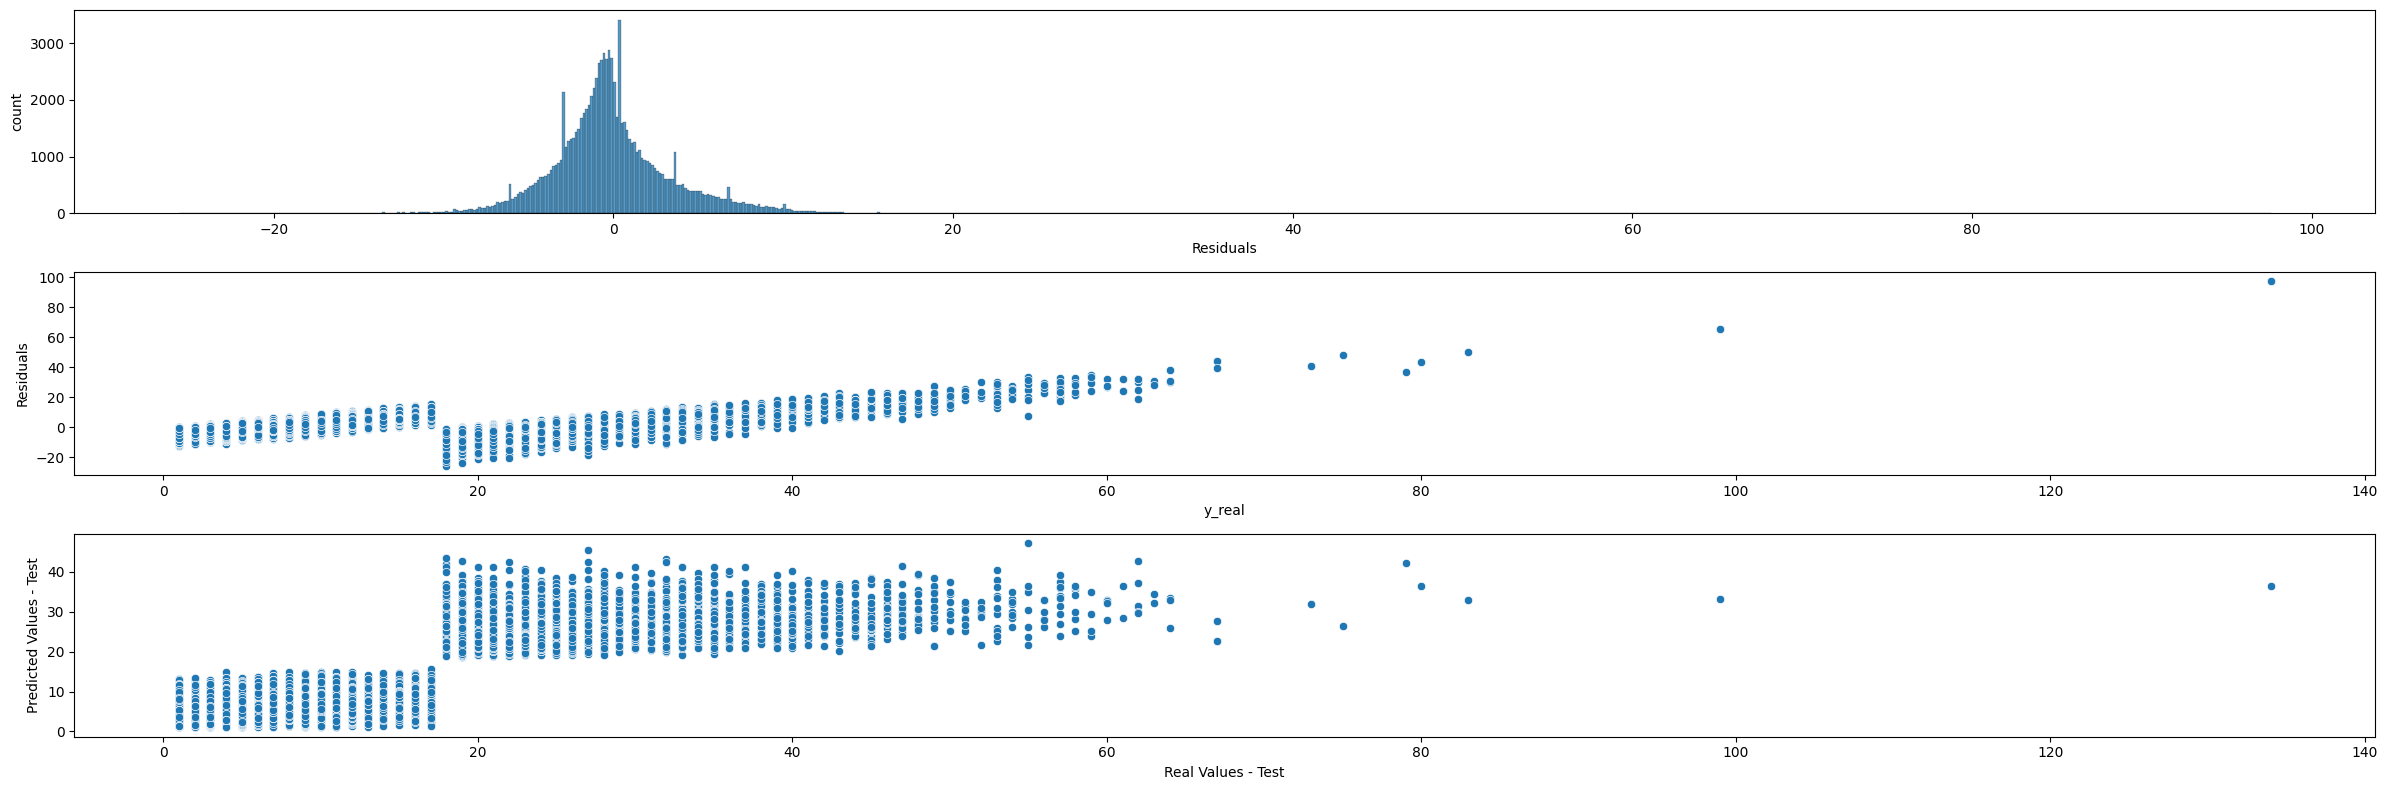

In [19]:
plot_real_predicted('test', y_test, y_test_pred)

In [20]:
y_test_pred_rounded = np.round(y_test_pred, decimals=0)

In [21]:
y_train_pred_rounded = np.round(y_train_pred, decimals=0)

In [22]:
error_metrics_report(y_train, y_test, y_train_pred_rounded, y_test_pred_rounded)

,Metric,Train,Test
0,MAE,2.21,2.57
1,MSE,10.05,13.51
2,RMSE,3.17,3.68
3,R2,0.75,0.67


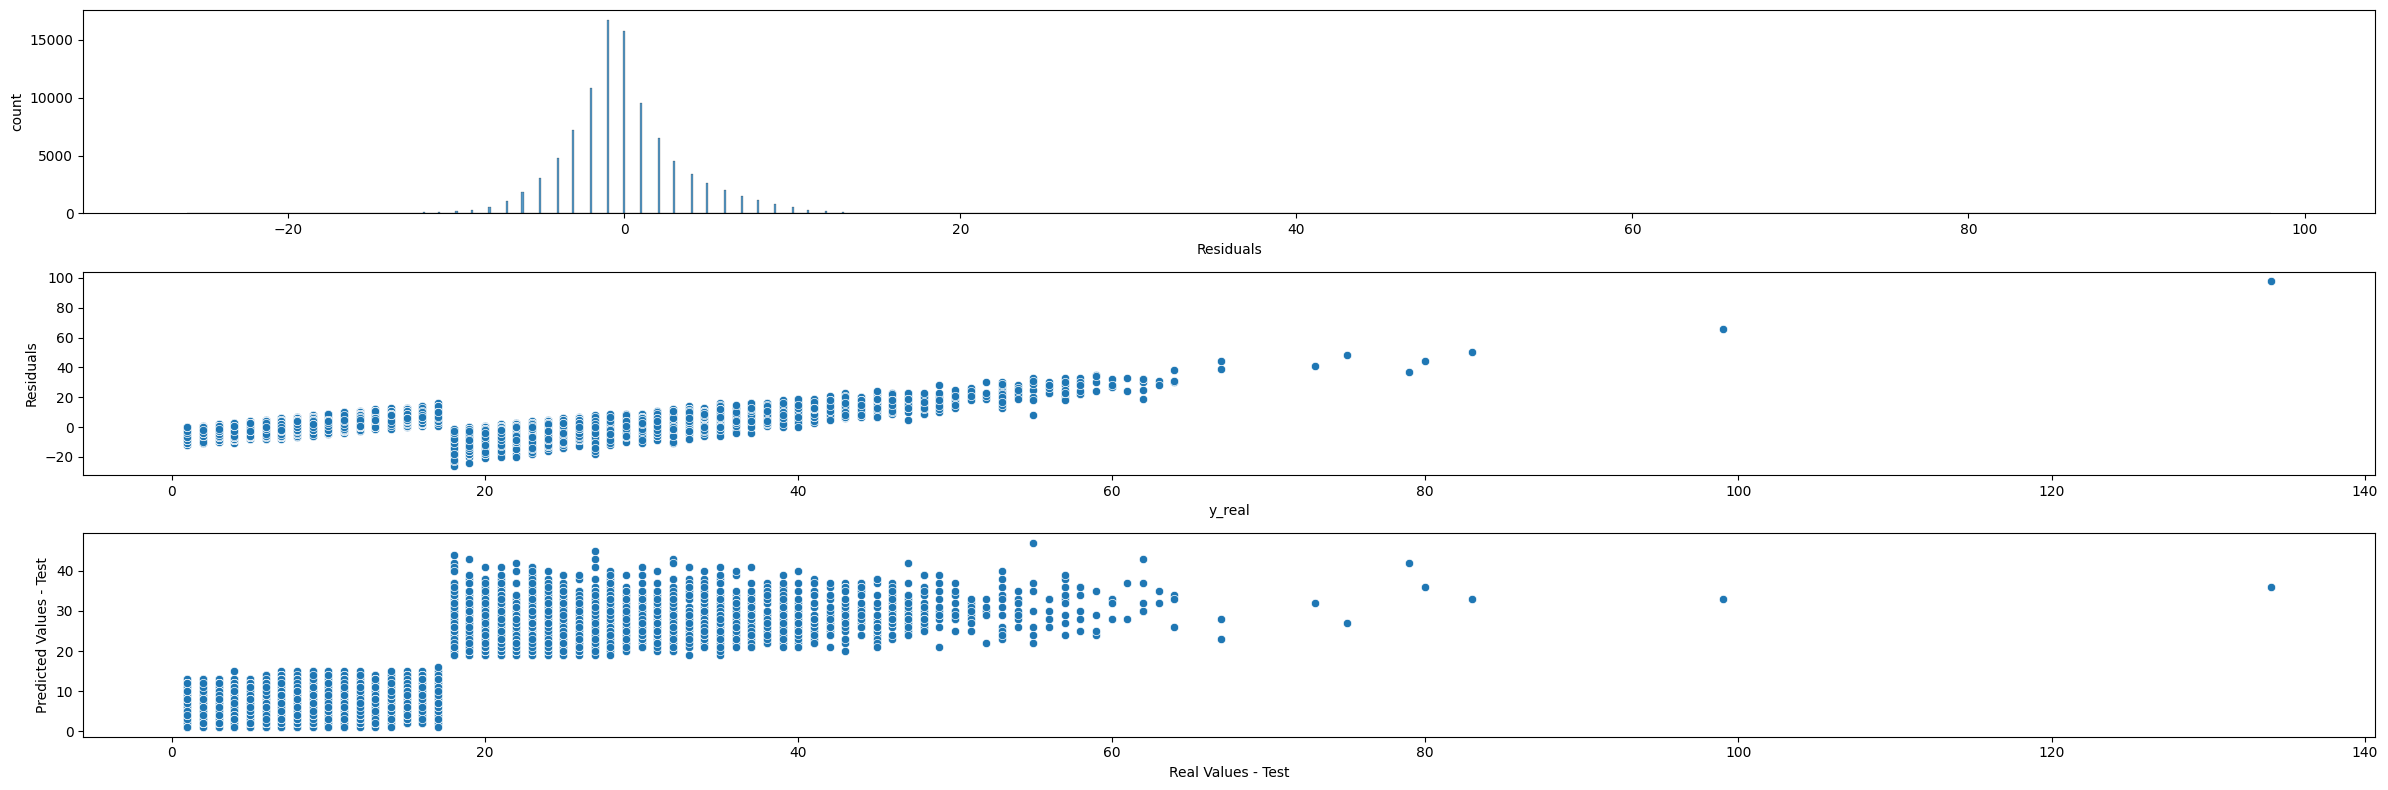

In [23]:
plot_real_predicted('test', y_test, y_test_pred_rounded)